##### Imports:
Import packages and load modells

In [1]:
from collections import Counter

import numpy as np
import spacy
from spacy import displacy
from spacy.lang.de import German
from spacy.lang.de.stop_words import STOP_WORDS
from matplotlib import pyplot as plt
import re

from sklearn.decomposition import NMF, LatentDirichletAllocation, TruncatedSVD
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.manifold import TSNE

import pyLDAvis.sklearn

import string


from enum import Enum

nlp = spacy.load('de_core_news_md')


##### Preprocessing and structure:

In [2]:
class Party(Enum):
    AFD = 0
    CDU = 1
    FDP = 2
    GRUENE = 3
    LINKE = 4
    SPD = 5


In [3]:
def all_statistics(party: Party):
    with open('../resources/' + party.name + '.txt', encoding='utf-8', errors='ignore') as txt:
        file = " ".join(l.rstrip() for l in txt)
    text = nlp(file)
    words = [token.lemma_ for token in text
             if not (token.is_stop
                     or token.is_punct
                     or token.is_space
                     or token.like_num
                     or token.like_url
                     or token.like_email
                     or token.is_currency
                     or token.text.upper() == party.name
                     or token.pos_ == 'VBZ'  # Verb, 3rd person singular present
                     or token.pos_ == 'ADP'  # adposition
                     or token.pos_ == 'PRON'  # pronoun
                     or token.pos_ == 'AUX'  # auxiliary
                     or token.text == '>'
                     or (party == Party.FDP and (token.text == 'Freie' or token.text == 'Demokraten'))
                     or not re.match('[\x00-\x7F]+', token.text))]  # remove non ascii
    word_freq = Counter(words)
    most_freq_nouns = word_freq.most_common(50)
    words_as_text = " ".join([word for word in words])
    return text, words, word_freq, most_freq_nouns, words_as_text

Gather statistics for all parties

In [4]:
# statistics_tuple = (text, words, word_freq, most_freq_nouns, words_as_text)
statistics = {}

for party in Party:
    statistics[party] = all_statistics(party)

print('Loading statistics is finished!')


Loading statistics is finished!


##### Plotting:

In [5]:
def plottingPng(most_freq_words, name, show_plot=True, save_plot=False):
    ranked_frequencies = []
    x_axis = []
    y_axis = []

    for i, word in zip(range(len(most_freq_words)), most_freq_words):
        ranked_frequencies.insert(i, word)


    i = 0
    for (x, y) in ranked_frequencies:
        x_axis.insert(i, x)
        y_axis.insert(i, y)
        i += 1

    y = np.arange(50)
    plt.rcParams['figure.autolayout'] = True
    fig, ax = plt.subplots()
    ax.bar(y, y_axis, .5, color='blue')
    ax.set_xticks(y, labels=x_axis, rotation=45, ha='right')

    ax.tick_params(labelcolor='white')

    fig.set_figwidth(fig.get_figwidth() * 2)
    plt.title(name, color='white')

    if save_plot:
        plt.savefig('graphs/graph_' + name + '.svg', format='svg')
    if show_plot:
        plt.show()

Plot the most frequent words for all parties

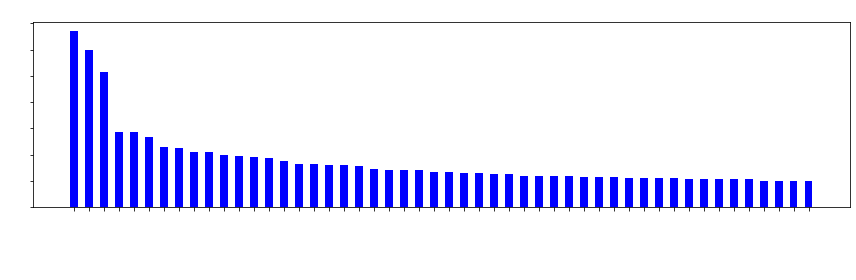

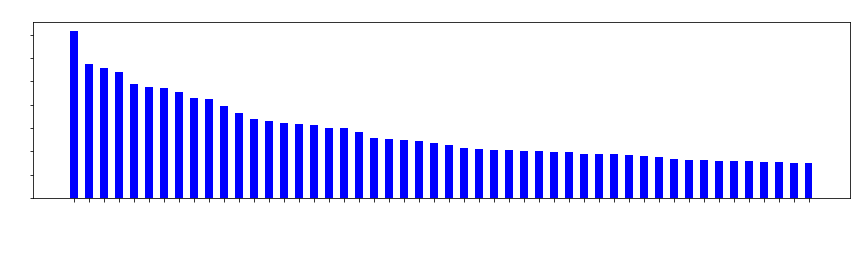

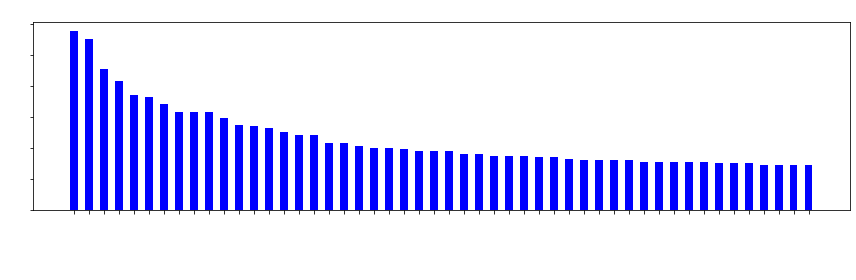

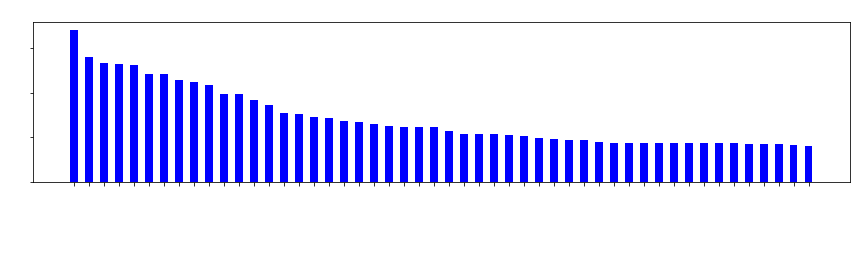

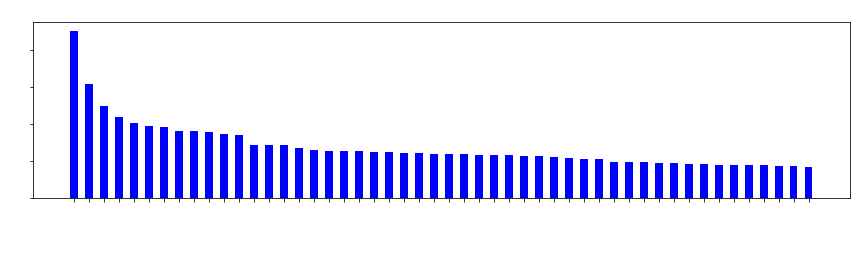

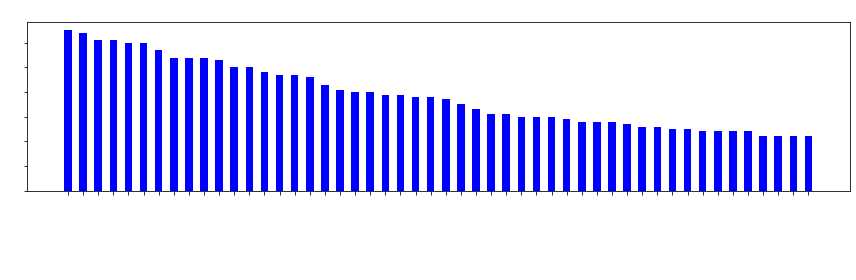

In [6]:
for party in Party:
    plottingPng(statistics[party][3], party.name)


In [7]:
def selected_topics(model, vectorizer, top_n=10):
    for idx, topic in enumerate(model.components_):
        print("Topic %d:" % (idx))
        print([(vectorizer.get_feature_names()[i], topic[i])
                        for i in topic.argsort()[:-top_n - 1:-1]])

In [35]:
with open('resources/CDU.txt', encoding='utf-8', errors='ignore') as txt:
        file = "".join(l for l in txt)

#file = nlp(file)
#spacy.displacy.render(doc, style='ent',jupyter=True)

punctuations = string.punctuation
stopwords = list(STOP_WORDS)

# review = str(" ".join([i.lemma_ for i in doc]))
#
# doc = nlp(review)
# spacy.displacy.render(doc, style='ent',jupyter=True)

def spacy_tokenizer(sentence):
    # TODO: Problem mit Umlaut???
    mytokens = nlp(sentence)
    # print("A",mytokens)
    mytokens = [ word.lemma_.lower().strip() if word.lemma_ != "-PRON-" else word.lower_ for word in mytokens ]

    mytokens = [ word for word in mytokens if word not in stopwords and word not in punctuations ]
    mytokens = " ".join([i for i in mytokens])
    return mytokens



vectorizer = CountVectorizer(min_df=.01, max_df=0.9, lowercase=True, token_pattern='[a-zA-Z\-][a-zA-Z\-]{2,}')

data_vectorizer_FDP = vectorizer.fit_transform(map(spacy_tokenizer, file.split("\n\n")))

NUM_TOPICS = 20

lda = LatentDirichletAllocation(n_components=NUM_TOPICS, max_iter=20, learning_method='online',verbose=True)
data_lda = lda.fit_transform(data_vectorizer_FDP)

nmf = NMF(n_components=NUM_TOPICS)
data_nmf = nmf.fit_transform(data_vectorizer_FDP)

lsi = TruncatedSVD(n_components=NUM_TOPICS)
data_lsi = lsi.fit_transform(data_vectorizer_FDP)

print("LDA Model:")
selected_topics(lda, vectorizer)

print("NMF Model:")
selected_topics(nmf, vectorizer)

print("LSI Model:")
selected_topics(lsi, vectorizer)

pyLDAvis.enable_notebook()
dash = pyLDAvis.sklearn.prepare(lda, data_vectorizer_FDP, vectorizer, mds='tsne')
dash

<>:26: DeprecationWarning: invalid escape sequence \-
<>:26: DeprecationWarning: invalid escape sequence \-
C:\Users\fabik\AppData\Local\Temp/ipykernel_13256/2123948120.py:26: DeprecationWarning: invalid escape sequence \-
  vectorizer = CountVectorizer(min_df=.01, max_df=0.9, lowercase=True, token_pattern='[a-zA-Z\-][a-zA-Z\-]{2,}')


length: 2762
iteration: 1 of max_iter: 20
iteration: 2 of max_iter: 20
iteration: 3 of max_iter: 20
iteration: 4 of max_iter: 20
iteration: 5 of max_iter: 20
iteration: 6 of max_iter: 20
iteration: 7 of max_iter: 20
iteration: 8 of max_iter: 20
iteration: 9 of max_iter: 20
iteration: 10 of max_iter: 20
iteration: 11 of max_iter: 20
iteration: 12 of max_iter: 20
iteration: 13 of max_iter: 20
iteration: 14 of max_iter: 20
iteration: 15 of max_iter: 20
iteration: 16 of max_iter: 20
iteration: 17 of max_iter: 20
iteration: 18 of max_iter: 20
iteration: 19 of max_iter: 20
iteration: 20 of max_iter: 20


c:\users\fabik\pycharmprojects\textanalytics\venv\lib\site-packages\sklearn\decomposition\_nmf.py:289: FutureWarning: The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).
  warnings.warn(
c:\users\fabik\pycharmprojects\textanalytics\venv\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


LDA Model:
Topic 0:
[('ffentlich', 40.14240295028272), ('einfach', 0.050001336467612144), ('landwirtschaft', 0.05000111267471265), ('weg', 0.050001081727529664), ('all', 0.05000100189874101), ('weiterentwickel', 0.05000094977218338), ('schnellen', 0.05000073793807784), ('rdern', 0.05000063303575729), ('nftig', 0.050000618690849076), ('ausbauen', 0.05000061712522764)]
Topic 1:
[('ren', 51.855035330844196), ('einsetzen', 33.50798113674708), ('demokratie', 30.886873836350432), ('bringen', 28.188537911057292), ('weg', 8.160702551756733), ('ndlich', 0.05002117469049089), ('mensch', 0.05001123201701946), ('stehen', 0.0500056740800541), ('unternehmen', 0.05000369749951092), ('seite', 0.05000310709012366)]
Topic 2:
[('wirtschaft', 45.625516827067564), ('zukunft', 36.24852034630958), ('sichern', 35.60091406130212), ('gestalten', 33.557551046698585), ('hig', 31.01274728795863), ('tze', 30.767473596390037), ('herausforderung', 18.16909342866168), ('gemeinsam', 9.886918900593011), ('ziel', 8.47666

c:\users\fabik\pycharmprojects\textanalytics\venv\lib\site-packages\pyLDAvis\_prepare.py:246: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  default_term_info = default_term_info.sort_values(
c:\users\fabik\pycharmprojects\textanalytics\venv\lib\site-packages\sklearn\manifold\_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
c:\users\fabik\pycharmprojects\textanalytics\venv\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
c:\users\fabik\pycharmprojects\textanalytics\venv\lib\site-packages\sklearn\manifold\_t_sne.py:819: FutureWarning: 'square_distances' has been introduced in 0.24 to help phase out legacy squaring behavior. The 'legacy' setting will be removed in 1.1 (renaming of 0.26), and the default setting will be cha

PreparedData(topic_coordinates=                x           y  topics  cluster      Freq
topic                                                   
14     -10.878068   10.538728       1        1  8.053831
16     -60.884026  -75.591820       2        1  8.029922
3       -2.336119  -53.289074       3        1  7.595241
10     -61.385319  -12.914634       4        1  6.651896
8      -28.737743  126.296997       5        1  5.684915
11       1.066606 -123.552811       6        1  5.615497
19      45.140720   -7.947869       7        1  5.600571
13    -140.795975  -98.530548       8        1  5.276641
18      61.531681  -83.240562       9        1  4.838519
17     -72.563057 -140.396881      10        1  4.787400
2       15.984491   63.578186      11        1  4.782987
5     -160.851624   68.945145      12        1  4.650045
7       85.961830   51.922935      13        1  4.307721
15     -99.020836  109.936348      14        1  4.204367
4     -176.764130   -8.681684      15        1  4.136317
9     -117.189880  -37.420200      16        1  3.964895
6      108.829918  -22.946203      17        1  3.866015
12      47.588097  121.934814      18        1  3.375829
1     -106.467834   30.176889      19        1  3.120870
0      -50.613804   59.328842      20        1  1.456522, topic_info=           Term        Freq       Total Category  logprob  loglift
14  deutschland  180.000000  180.000000  Default  30.0000  30.0000
68         rken  148.000000  148.000000  Default  29.0000  29.0000
25        europ  163.000000  163.000000  Default  28.0000  28.0000
73        seite  120.000000  120.000000  Default  27.0000  27.0000
63        rdern  114.000000  114.000000  Default  26.0000  26.0000
..          ...         ...         ...      ...      ...      ...
75   sicherheit    0.093363   68.788254  Topic20  -6.8078  -2.3732
99   wirtschaft    0.093363   49.443756  Topic20  -6.8078  -2.0430
7      brauchen    0.093363   81.507066  Topic20  -6.8078  -2.5428
51         land    0.093363  129.464355  Topic20  -6.8078  -3.0055
66         rger    0.093363   47.729138  Topic20  -6.8078  -2.0077

[993 rows x 6 columns], token_table=      Topic      Freq            Term
term                                 
0         1  0.606147             all
0         5  0.151537             all
0        14  0.132595             all
0        18  0.104182             all
1         6  0.978890           ander
...     ...       ...             ...
100       8  0.673907            ziel
100      11  0.144409            ziel
100      15  0.160454            ziel
101      11  0.961923         zukunft
102      15  0.986328  zusammenarbeit

[139 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[15, 17, 4, 11, 9, 12, 20, 14, 19, 18, 3, 6, 8, 16, 5, 10, 7, 13, 2, 1])